In [1]:
import numpy as np
import pandas as pd

def load_football():
    df = pd.read_csv('football.csv', delimiter=';')
    
    return df

In [2]:
df = load_football()
names = list(df.columns)

test = df[df["GoalsScored"].isna()]
train = df[~df["GoalsScored"].isna()]

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X, y = train.drop(columns=["GoalsScored"]), train["GoalsScored"]
X = scaler.fit_transform(X)

# GLMs require intercept
X = np.hstack((np.ones((X.shape[0], 1)), X))    # (n_samples, n_features + 1)
y = y.to_numpy().flatten().astype(int)

In [4]:
train.isna().sum()  # Check for any remaining NaN values in the training set

X_ScoreRateH      0
X_ScoreRateA      0
X_ConcedeRateH    0
X_ConcedeRateA    0
X_CornerRatioH    0
X_CornerRatioA    0
X_FoulRatioH      0
X_FoulRatioA      0
GoalsScored       0
dtype: int64

Poisson GLM: \
p(Beta | y) = p(y | Beta) * p(Beta) \
Poisson = Poisson(Exp) * Normal 

In [5]:
X.shape, type(y), y.shape  # Check the shape of X and type of y

((1750, 9), numpy.ndarray, (1750,))

In [6]:
# https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html
import pymc as pm

# alpha + beta X
alpha = 5
with pm.Model(coords={"predictors": names[:-1]}) as model:
    _X = pm.Data("X", X)  
    _y = pm.Data("y", y)
    
    # Define the prior for alpha
    beta = pm.Normal("beta", mu=0, sigma=alpha, shape=X.shape[1])

    # Define the likelihood
    mu = pm.math.exp(pm.math.dot(_X, beta))   # lambda = exp(X @ beta) = log link
    y_obs = pm.Poisson("y_obs", mu=mu, observed=_y)  # Likelihood
    
    # Get inference data
    idata = pm.sample(1000, tune=1000, return_inferencedata=True, chains=5)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 4 jobs)
NUTS: [beta]


Output()

Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 20 seconds.


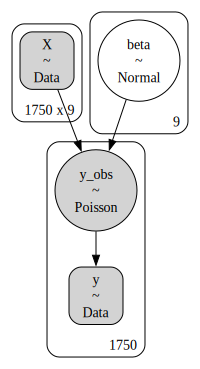

In [7]:
pm.model_to_graphviz(model)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

In [9]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

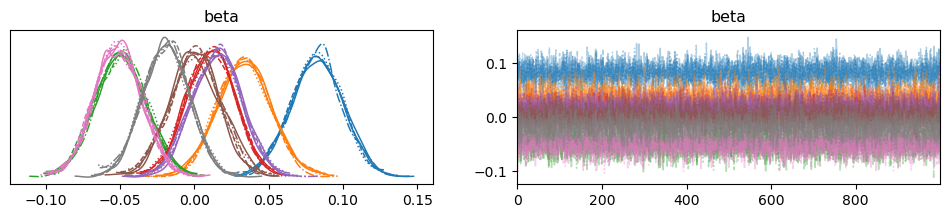

In [10]:
az.plot_trace(idata, coords={"beta_dim_0": list(range(1, 9))}, combined=False, var_names=["beta"])

In [11]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=123)

Sampling: [y_obs]


Output()

<Axes: xlabel='y_obs'>

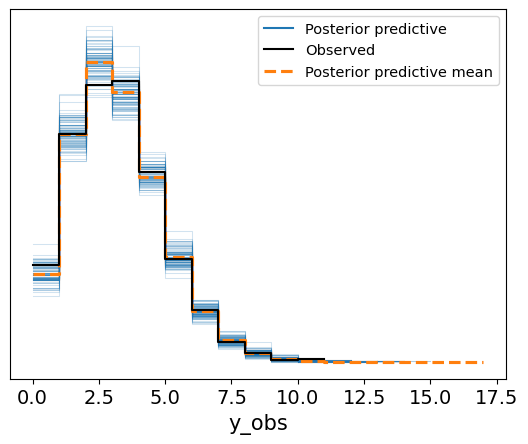

In [15]:
az.plot_ppc(idata, num_pp_samples=100)

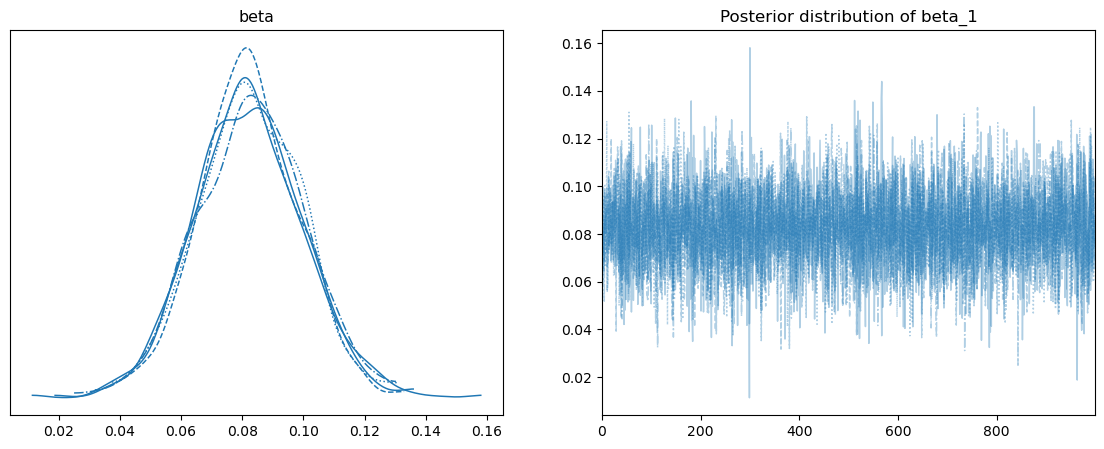

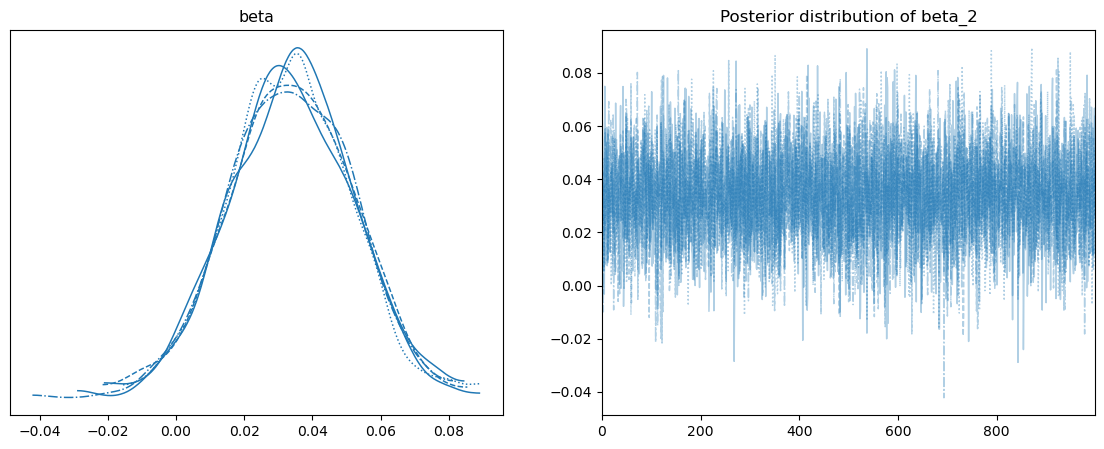

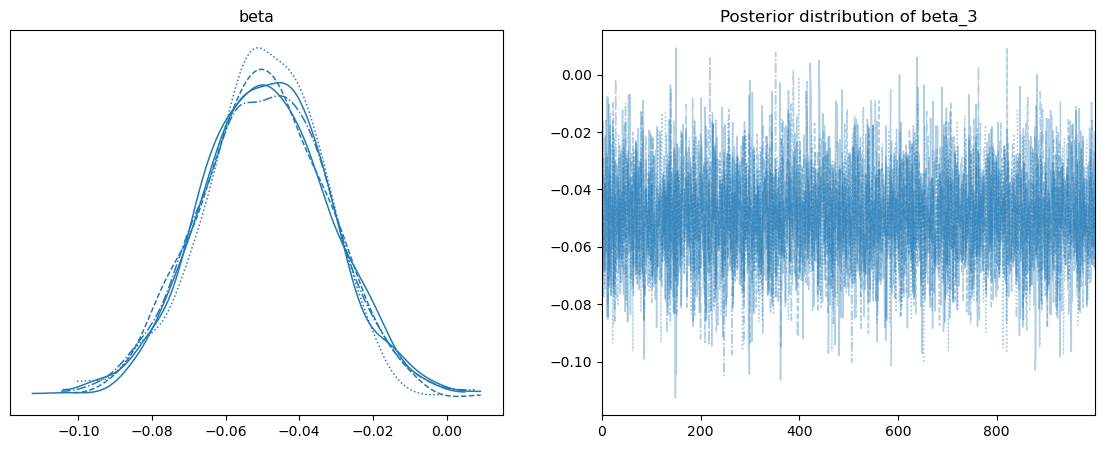

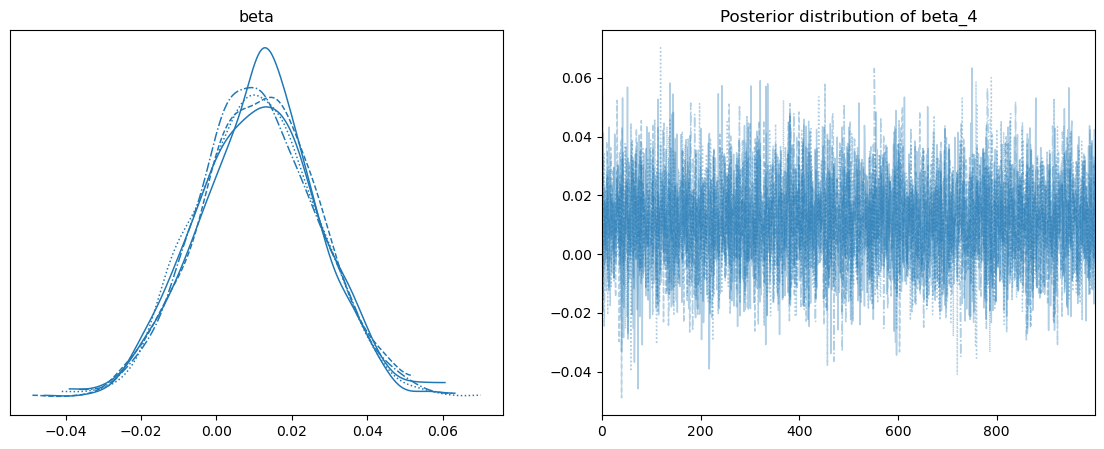

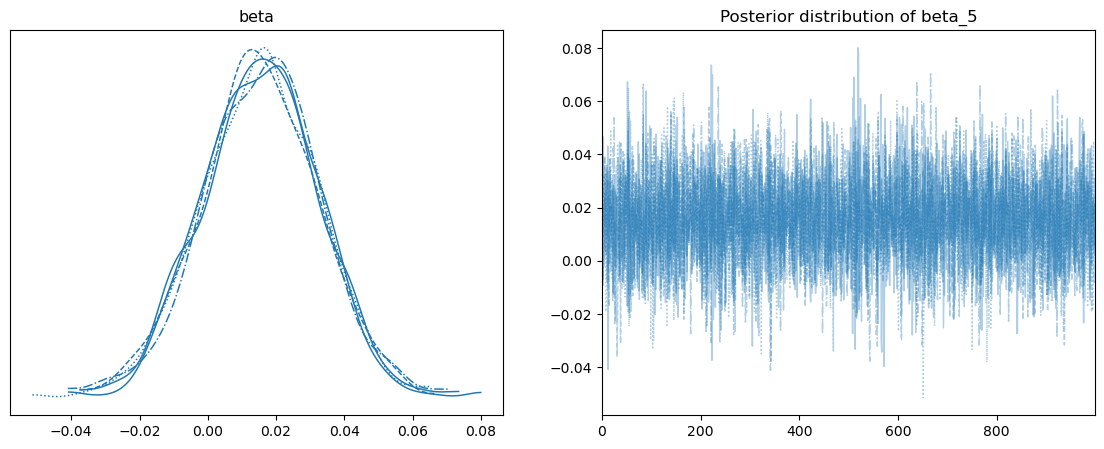

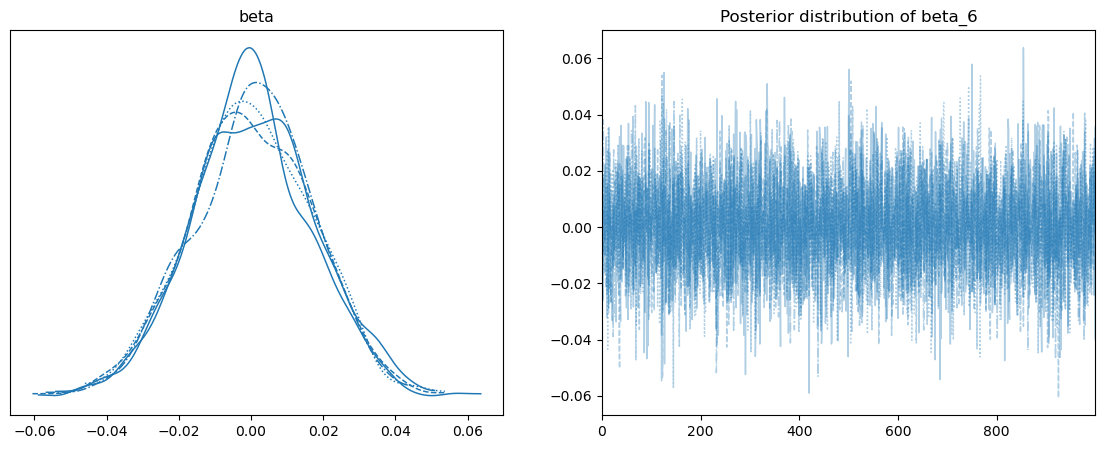

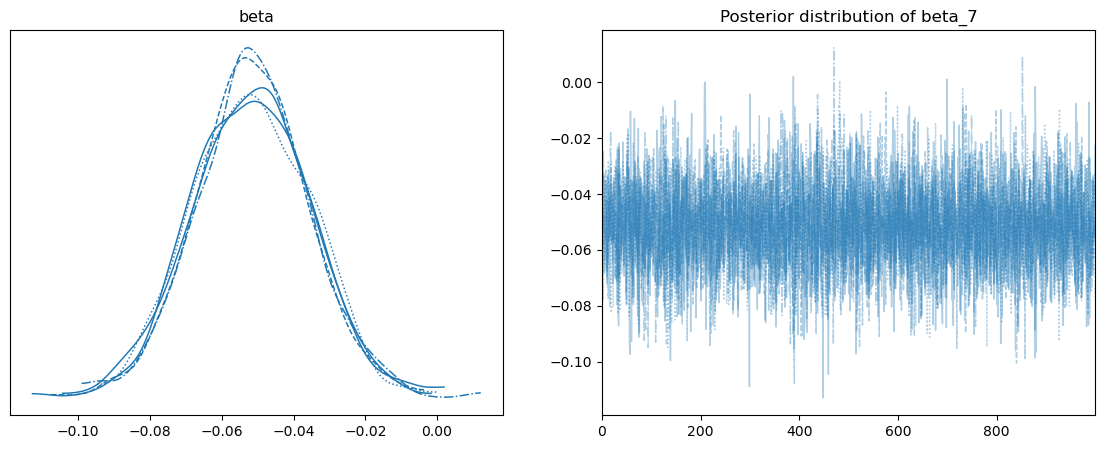

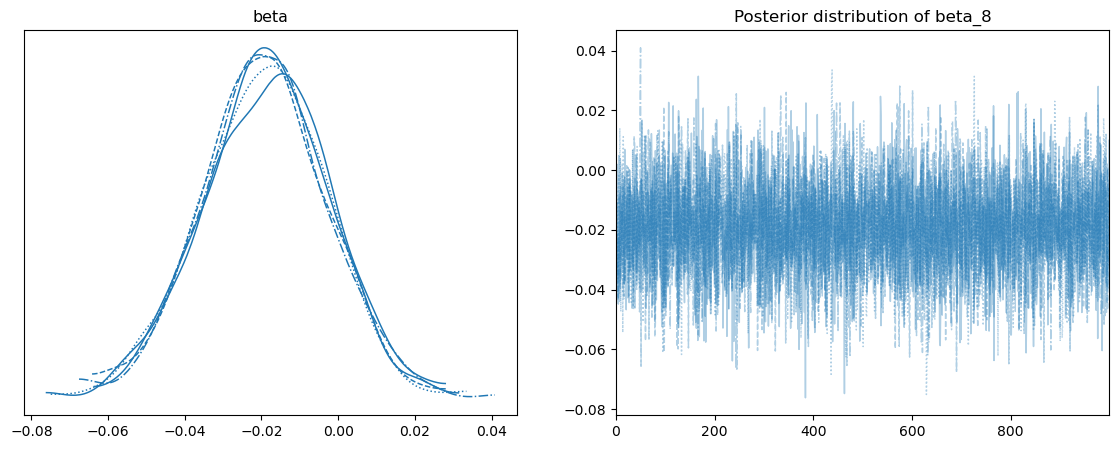

In [107]:
for i in range(1, 9):
    az.plot_trace(idata, coords={"beta_dim_0": i}, var_names=["beta"], figsize=(14, 5), combined=False)
    plt.title(f"Posterior distribution of beta_{i}")
    plt.show()

In [99]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.999,0.015,0.973,1.028,0.0,0.0,7692.0,3903.0,1.0
beta[1],0.082,0.017,0.051,0.114,0.0,0.0,7557.0,4066.0,1.0
beta[2],0.034,0.018,-0.001,0.065,0.0,0.0,6645.0,3894.0,1.0
beta[3],-0.049,0.017,-0.081,-0.017,0.0,0.0,6989.0,3957.0,1.0
beta[4],0.011,0.016,-0.020,0.039,0.0,0.0,7650.0,4105.0,1.0
beta[5],0.015,0.017,-0.016,0.046,0.0,0.0,7364.0,3848.0,1.0
beta[6],0.000,0.017,-0.031,0.032,0.0,0.0,7057.0,3237.0,1.0
beta[7],-0.052,0.016,-0.080,-0.021,0.0,0.0,7178.0,3875.0,1.0
beta[8],-0.019,0.016,-0.049,0.011,0.0,0.0,8039.0,4085.0,1.0


<Axes: >

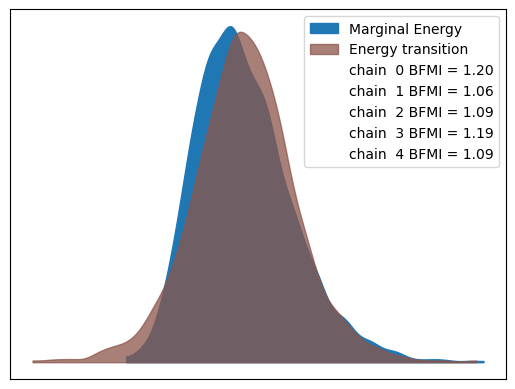

In [100]:
az.plot_energy(idata)

(-0.2, 0.2)

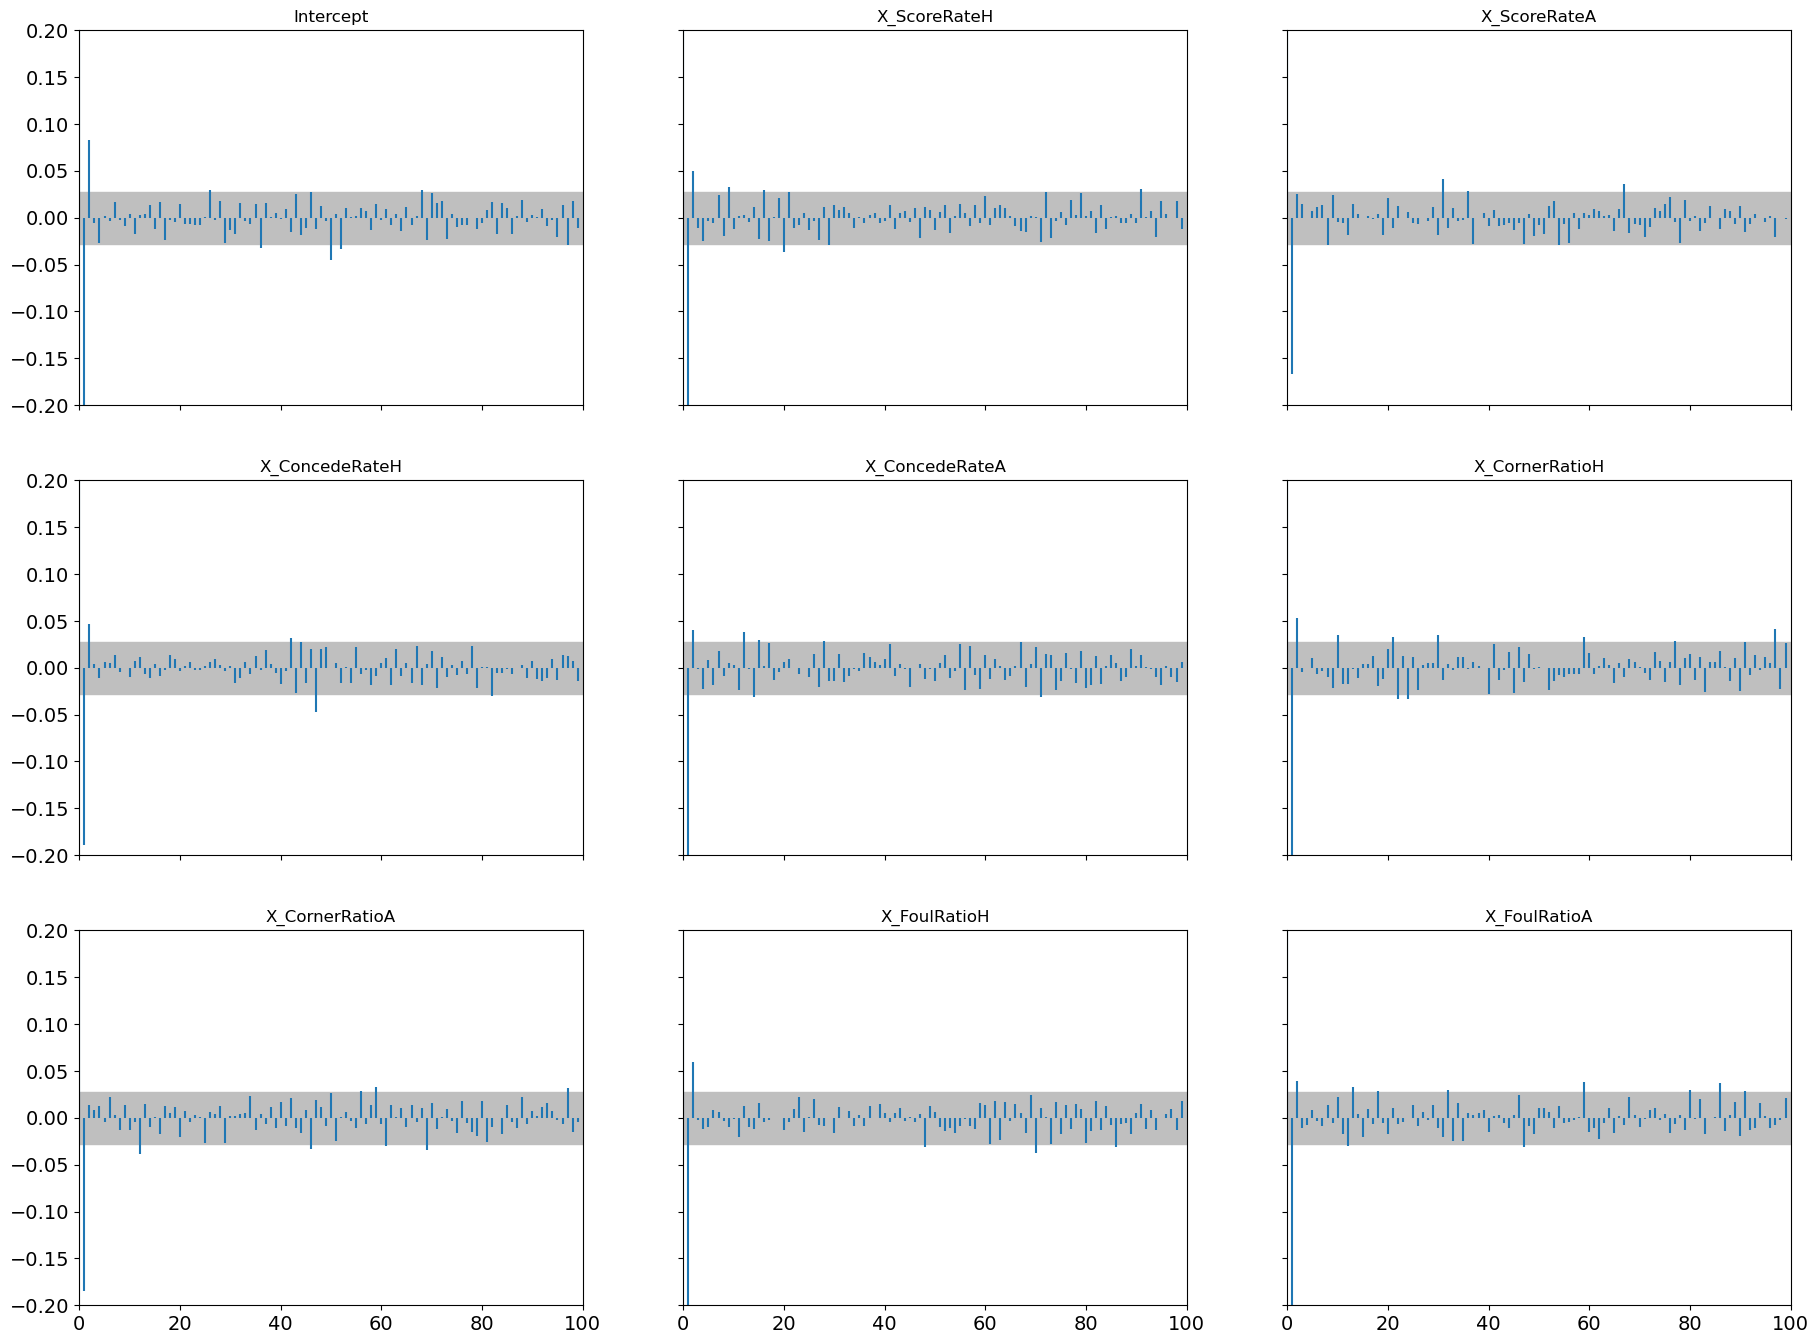

In [122]:
ax = az.plot_autocorr(idata, var_names=["beta"], combined=True)
ax = ax.flatten()
for i in range(9):
    ax[i].set_title(names[i-1])
    if i == 0:
        ax[i].set_title("Intercept")
plt.ylim(-0.2, 0.2)

array([[<Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'beta\n1'}>,
        <Axes: title={'center': 'beta\n2'}>],
       [<Axes: title={'center': 'beta\n3'}>,
        <Axes: title={'center': 'beta\n4'}>,
        <Axes: title={'center': 'beta\n5'}>],
       [<Axes: title={'center': 'beta\n6'}>,
        <Axes: title={'center': 'beta\n7'}>,
        <Axes: title={'center': 'beta\n8'}>]], dtype=object)

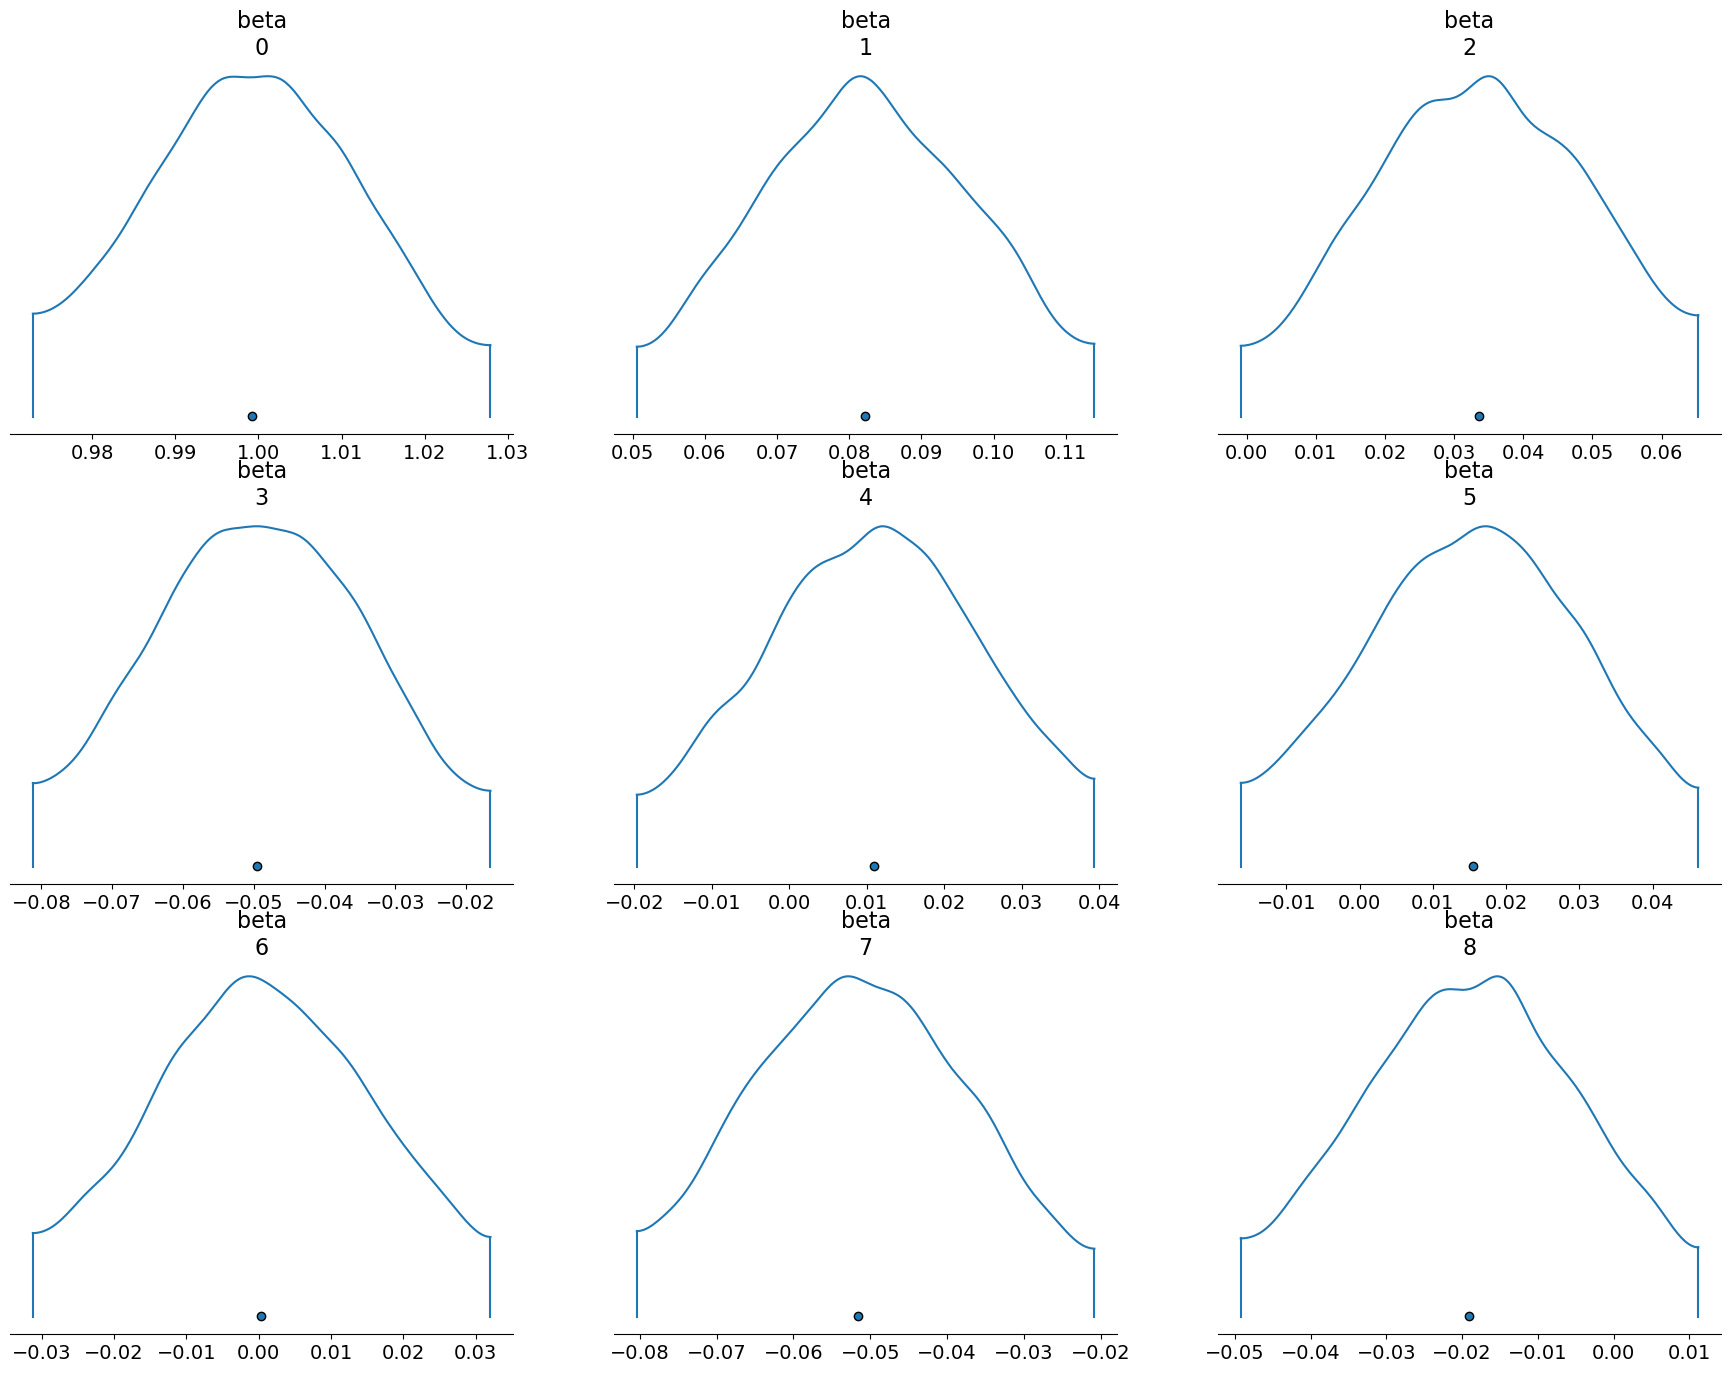

In [102]:
az.plot_density(idata, var_names=["beta"])